In [6]:
import uproot4
import numpy as np
import pandas as pd
import numba
import seaborn as sns
import awkward as ak
from scipy.stats import norm
from scipy.optimize import curve_fit
from coffea import hist
from coffea.processor import defaultdict_accumulator
import os
import copy

import optparse
import importlib
import pathlib

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
plt.style.use(hep.style.ROOT)

#Just to efficiently save plots
plot_dir = "plot/"
from datetime import datetime
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y")
save_path = plot_dir + dt_string

print("Saving plots to: ", save_path)

#Plot settings
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'small',
         'axes.labelsize': 'large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#line thickness
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 5

## Data processing codes
def getData(fname="", treeName="Truth"):
    dq_dict_ak1 = uproot4.lazy(fname+":"+treeName)
    dq_events = ak.zip({
                        "nTrack": ak.zip({
                                "n_tracks": dq_dict_ak1['n_tracks']
                        }),
                        "hit": ak.zip({
                                "detID": dq_dict_ak1['hit_detID']
                        }),
                        "event_weight": ak.zip({
                                'weight': dq_dict_ak1['weight']
                        }),
        
                        "GenVertex": ak.zip({
                                            "x": dq_dict_ak1["gvx"],
                                            "y": dq_dict_ak1["gvy"],
                                            "z": dq_dict_ak1["gvz"],
                                            "px": dq_dict_ak1["gpx"],
                                            "py": dq_dict_ak1["gpy"],
                                            "pz": dq_dict_ak1["gpz"]

                        }),
                        "GenP_St1": ak.zip({
                                            "px": dq_dict_ak1["gpx_st1"],
                                            "py": dq_dict_ak1["gpy_st1"],
                                            "pz": dq_dict_ak1["gpz_st1"],
                                            "x": dq_dict_ak1["gx_st1"],
                                            "y": dq_dict_ak1["gy_st1"],
                                            "z": dq_dict_ak1["gz_st1"],
                        }),
                        "Track_St1": ak.zip({
                                            "px": dq_dict_ak1["track_px_st1"],
                                            "py": dq_dict_ak1["track_py_st1"],
                                            "pz": dq_dict_ak1["track_pz_st1"],
                                            "x": dq_dict_ak1["track_x_st1"],
                                            "y": dq_dict_ak1["track_y_st1"],
                                            "z": dq_dict_ak1["track_z_st1"],
                        }),
                        "reco_dimuon": ak.zip({
                                            "mass": dq_dict_ak1["dimuon_mass"],
                                            "x": dq_dict_ak1["dimuon_x_vtx"],
                                            "y": dq_dict_ak1["dimuon_y_vtx"],
                                            "z": dq_dict_ak1["dimuon_z_vtx"],
                                            "chisq": dq_dict_ak1["dimuon_chisq"],
                            
                        }),
                        "truth_dimuon":ak.zip({
                                            "mass": dq_dict_ak1['truthdimuon_mass'],
                                            "x": dq_dict_ak1['truthdimuon_x_vtx'],
                                            "y": dq_dict_ak1['truthdimuon_y_vtx'],
                                            "z": dq_dict_ak1['truthdimuon_z_vtx'],
                                            "px": dq_dict_ak1['truthdimuon_px'],
                                            "py": dq_dict_ak1['truthdimuon_py'],
                                            "pz": dq_dict_ak1['truthdimuon_pz'],
                            
                        }),
                        "fpga_trigger": ak.zip({"trigger": dq_dict_ak1["fpga_trigger"]
                            
                        }),
                       }, depth_limit=1)
    return dq_events

def log_inf(i):
    return None if i == 0 else np.log(i) 

def plot_acceptance(mass, coupling, Nevent, acceptance, hue_norm=(0, 1)):
    
    #Create the pandas data frame
    df = pd.DataFrame(data = {"mass": mass,
                        "coupling": coupling,
                        "Number of events":Nevent,
                        "Acceptance": [i for i in acceptance]})
    
    df = df.sort_values(['mass', 'coupling'])
    
    g = sns.relplot(data=df,
                x="mass", y="coupling", hue="Acceptance", size="Number of events",
                palette='YlGn',
                hue_norm=hue_norm,
                edgecolor=".7",
                height=10,
                sizes=(50, 250),
                size_norm=(0, 5000),)
    
    # iterate over axes of FacetGrid
    for ax in g.axes.flat:
        labels = ax.get_yticklabels() # get y labels
        
        new_labels = []
        for i,l in enumerate(labels):
            new_labels.append(r"$10^{%s}$"%labels[i].get_text())

        g.set(yticklabels = new_labels) # set new labels
    
    #Re-label the y axis
    g.set(xlabel=r"$m_{A'}$ [GeV]", ylabel=r"$\epsilon$", aspect="equal")
    plt.ylabel(ylabel=r"$\epsilon$", rotation = 0)

######## READ EVENTS
scan_dir = "/work/submit/dhoang/DQ/outfiles/Aprime_Muons_Scan_07_12_2021"

Saving plots to:  plot/03-01-2022


In [4]:
a =uproot4.open("/work/submit/dhoang/DQ/outfiles/Aprime_Muons_Scan_07_12_2021/Brem_0.250000_z500_600_eps_-5.8.root")

In [5]:
a['Events']['hit_detID']

<TBranch 'hit_detID' at 0x7f39c6806400>

<ReadOnlyDirectory '/' at 0x7f7b843ca610>

In [8]:
dq_events = getData("/work/submit/dhoang/DQ/outfiles/Aprime_Muons_Scan_07_12_2021/Brem_0.250000_z500_600_eps_-5.8.root",'Events')

In [16]:
dq_events['hit'].detID[0]

<Array [1, 1, 2, 2, 5, ... 52, 53, 53, 54, 54] type='85 * int32'>

In [17]:
for i in range(100):
    print(dq_events['hit'].detID)

[[1, 1, 2, 2, 5, 5, 6, 6, 3, 3, 4, ... 47, 48, 48, 51, 51, 52, 52, 53, 53, 54, 54]]
[[1, 1, 2, 2, 5, 5, 6, 6, 3, 3, 4, ... 47, 48, 48, 51, 51, 52, 52, 53, 53, 54, 54]]
[[1, 1, 2, 2, 5, 5, 6, 6, 3, 3, 4, ... 47, 48, 48, 51, 51, 52, 52, 53, 53, 54, 54]]
[[1, 1, 2, 2, 5, 5, 6, 6, 3, 3, 4, ... 47, 48, 48, 51, 51, 52, 52, 53, 53, 54, 54]]
[[1, 1, 2, 2, 5, 5, 6, 6, 3, 3, 4, ... 47, 48, 48, 51, 51, 52, 52, 53, 53, 54, 54]]
[[1, 1, 2, 2, 5, 5, 6, 6, 3, 3, 4, ... 47, 48, 48, 51, 51, 52, 52, 53, 53, 54, 54]]
[[1, 1, 2, 2, 5, 5, 6, 6, 3, 3, 4, ... 47, 48, 48, 51, 51, 52, 52, 53, 53, 54, 54]]
[[1, 1, 2, 2, 5, 5, 6, 6, 3, 3, 4, ... 47, 48, 48, 51, 51, 52, 52, 53, 53, 54, 54]]
[[1, 1, 2, 2, 5, 5, 6, 6, 3, 3, 4, ... 47, 48, 48, 51, 51, 52, 52, 53, 53, 54, 54]]
[[1, 1, 2, 2, 5, 5, 6, 6, 3, 3, 4, ... 47, 48, 48, 51, 51, 52, 52, 53, 53, 54, 54]]
[[1, 1, 2, 2, 5, 5, 6, 6, 3, 3, 4, ... 47, 48, 48, 51, 51, 52, 52, 53, 53, 54, 54]]
[[1, 1, 2, 2, 5, 5, 6, 6, 3, 3, 4, ... 47, 48, 48, 51, 51, 52, 52, 53, 53, 5

In [4]:
a['Events']['weight']

<TBranch 'weight' at 0x7f30b4186490>

## 0. Tracking reconstuction efficiency (fraction of events that have 2 tracks)

In [2]:
def scan_Ap_0(scan_dir):
    mass = []
    coupling = []
    Nevent = []
    acceptance = []

    #Loop through the files
    for filename in os.listdir(scan_dir):
        if filename.startswith("Brem"):
            
            #print(filename)
            
            #Parse some basic info
            Ap_config = filename[:-5].split('_') #Remove the .root part and split by '_'
            
            try:
                #Load file and calculate total number of events
                dq_events = getData(os.path.join(scan_dir, filename), 'Events')

                #Total events
                n_events = len(dq_events["GenVertex"].x)
                Nevent.append(n_events)

                #Number of events reconstructed but not triggered
                n_reco = ak.sum((ak.count(dq_events["Track_St1"].x, axis = 1) == 2)*dq_events['event_weight'].weight)

                mass.append(float(Ap_config[1]))
                coupling.append(float(Ap_config[-1]))
                acceptance.append(n_reco/n_events if n_events > 0 else 0)
            
            except:
                continue
            
#             print("---"*5)
#             print("Mass: ", Ap_config[1])
#             print("Coupling: ", Ap_config[-1])
#             print("Total number of events: ", n_events)
#             print("Number of events reconstructed", n_reco)
            
    return mass, coupling, Nevent, acceptance
            
mass_0, coupling_0, Nevent_0, acceptance_0 = scan_Ap_0(scan_dir)

/work/submit/dhoang/miniconda3/envs/Dimuon/lib/python3.8/site-packages/seaborn/axisgrid.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(**kwargs)


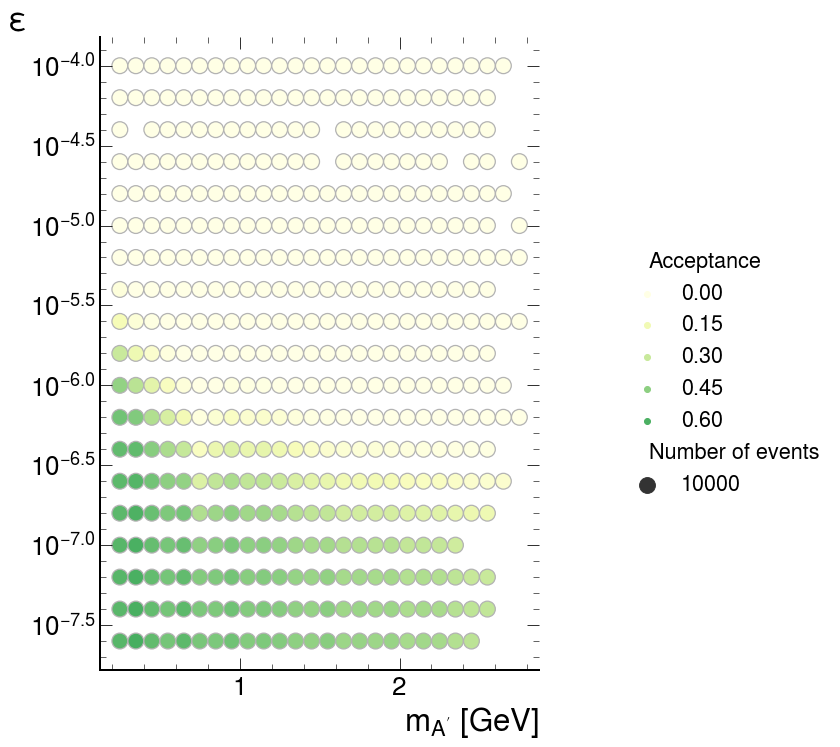

In [3]:
plot_acceptance(mass_0, coupling_0, Nevent_0, acceptance_0)

## 1. Fail all

In [4]:
def scan_Ap_1(scan_dir):
    mass = []
    coupling = []
    Nevent = []
    acceptance = []

    #Loop through the files
    for filename in os.listdir(scan_dir):
        if filename.startswith("Brem"):
            
            #print(filename)
            
            #Parse some basic info
            Ap_config = filename[:-5].split('_') #Remove the .root part and split by '_'
            
            try:
                #Load file and calculate total number of events
                dq_events = getData(os.path.join(scan_dir, filename), 'Events')

                #Total events
                n_events = len(dq_events["GenVertex"].x)
                Nevent.append(n_events)

                #Number of events reconstructed but not triggered
                n_reco = ak.sum((~(ak.count(dq_events["Track_St1"].x, axis = 1) == 2) &\
                                ~(dq_events["fpga_trigger"].trigger[:,0] == 1))*dq_events['event_weight'].weight)
                
                mass.append(float(Ap_config[1]))
                coupling.append(float(Ap_config[-1]))
                acceptance.append(n_reco/n_events if n_events > 0 else 0)
            
            except:
                continue
            
#             print("---"*5)
#             print("Mass: ", Ap_config[1])
#             print("Coupling: ", Ap_config[-1])
#             print("Total number of events: ", n_events)
#             print("Number of events reconstructed", n_reco)
            
    return mass, coupling, Nevent, acceptance
            
mass_1, coupling_1, Nevent_1, acceptance_1 = scan_Ap_1(scan_dir)

/work/submit/dhoang/miniconda3/envs/Dimuon/lib/python3.8/site-packages/seaborn/axisgrid.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(**kwargs)


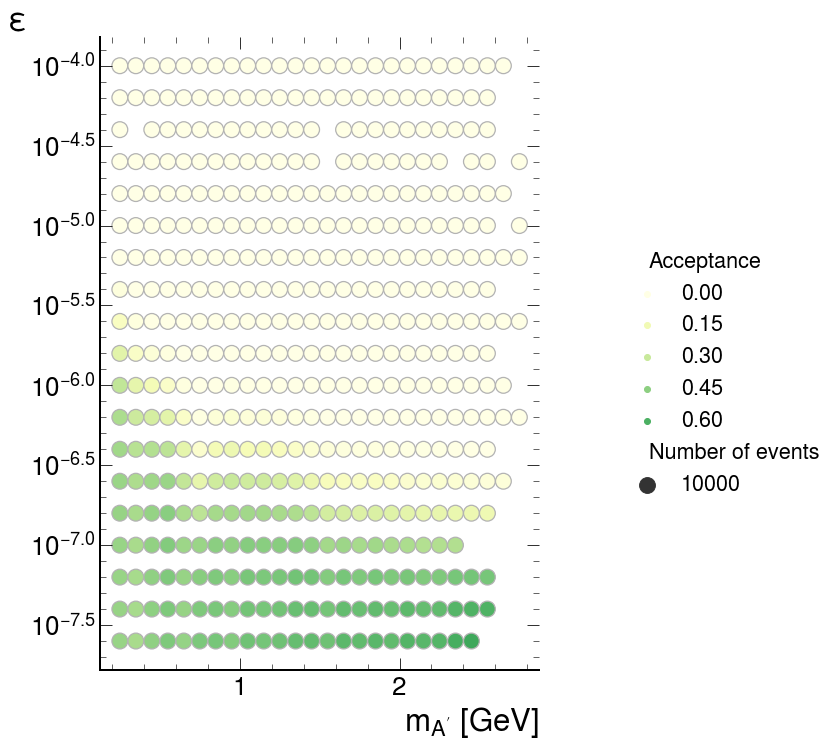

In [5]:
plot_acceptance(mass_1, coupling_1, Nevent_1, acceptance_1)

## 2. Pass track but not trigger

In [6]:
def scan_Ap_2(scan_dir):
    mass = []
    coupling = []
    Nevent = []
    acceptance = []

    #Loop through the files
    for filename in os.listdir(scan_dir):
        if filename.startswith("Brem"):
            
            #Parse some basic info
            Ap_config = filename[:-5].split('_') #Remove the .root part and split by '_'
            
            try:
                #Load file and calculate total number of events
                dq_events = getData(os.path.join(scan_dir, filename), 'Events')

                #Total events
                n_events = len(dq_events["GenVertex"].x)
                Nevent.append(n_events)

                #Number of events reconstructed but not triggered
                n_reco = ak.sum(((ak.count(dq_events["Track_St1"].x, axis = 1) == 2) &\
                                ~(dq_events["fpga_trigger"].trigger[:,0] == 1))*dq_events['event_weight'].weight)
                
                mass.append(float(Ap_config[1]))
                coupling.append(float(Ap_config[-1]))
                acceptance.append(n_reco/n_events if n_events > 0 else 0)
            
            except:
                continue
            
#             print("---"*5)
#             print("Mass: ", Ap_config[1])
#             print("Coupling: ", Ap_config[-1])
#             print("Total number of events: ", n_events)
#             print("Number of events reconstructed", n_reco)
            
    return mass, coupling, Nevent, acceptance
            
mass_2, coupling_2, Nevent_2, acceptance_2 = scan_Ap_2(scan_dir)

/work/submit/dhoang/miniconda3/envs/Dimuon/lib/python3.8/site-packages/seaborn/axisgrid.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(**kwargs)


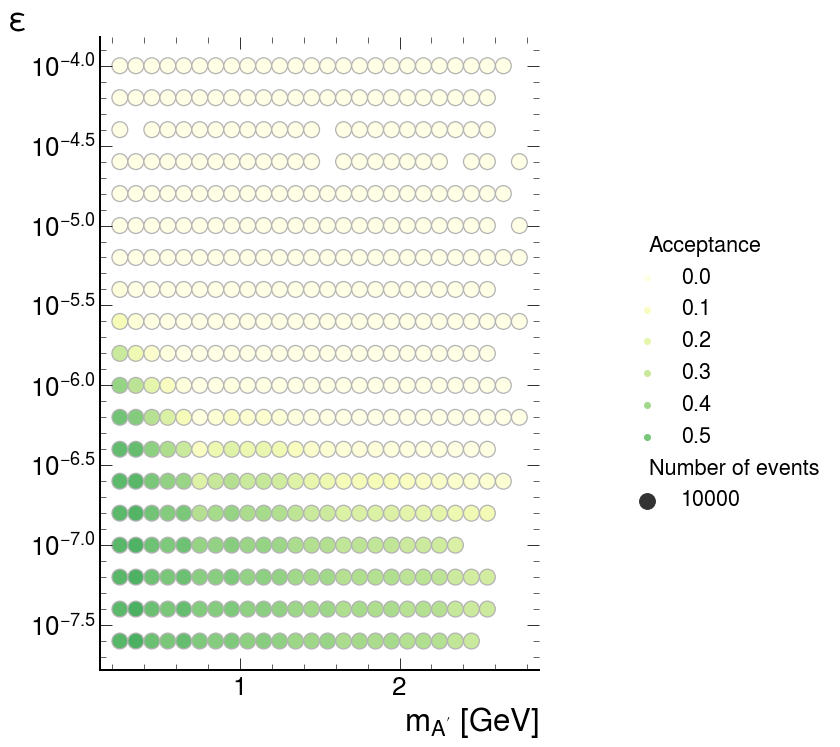

In [7]:
plot_acceptance(mass_2, coupling_2, Nevent_2, acceptance_2)

## 3. Pass trigger but not track

In [8]:
def scan_Ap_3(scan_dir):
    mass = []
    coupling = []
    Nevent = []
    acceptance = []

    #Loop through the files
    for filename in os.listdir(scan_dir):
        if filename.startswith("Brem"):
            
            try:
                #Parse some basic info
                Ap_config = filename[:-5].split('_') #Remove the .root part and split by '_'

                #Load file and calculate total number of events
                dq_events = getData(os.path.join(scan_dir, filename), 'Events')

                #Total events
                n_events = len(dq_events["GenVertex"].x)
                Nevent.append(n_events)

                #Number of events reconstructed but not triggered
                n_reco = ak.sum((~(ak.count(dq_events["Track_St1"].x, axis = 1) == 2) &\
                                (dq_events["fpga_trigger"].trigger[:,0] == 1))**dq_events['event_weight'].weight)

                acceptance.append(n_reco/n_events if n_events > 0 else 0)
                mass.append(float(Ap_config[1]))
                coupling.append(float(Ap_config[-1]))
            
            except:
                continue
            
#             print("---"*5)
#             print("Mass: ", Ap_config[1])
#             print("Coupling: ", Ap_config[-1])
#             print("Total number of events: ", n_events)
#             print("Number of events reconstructed", n_reco)
            
    return mass, coupling, Nevent, acceptance
            
mass_3, coupling_3, Nevent_3, acceptance_3 = scan_Ap_3(scan_dir)

/work/submit/dhoang/miniconda3/envs/Dimuon/lib/python3.8/site-packages/seaborn/axisgrid.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(**kwargs)


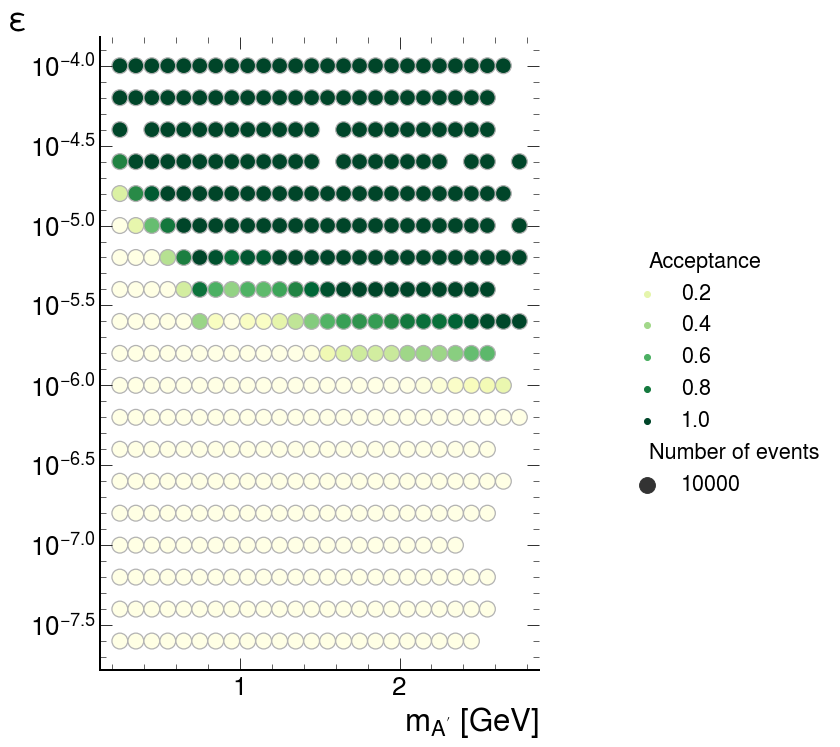

In [9]:
plot_acceptance(mass_3, coupling_3, Nevent_3, acceptance_3)

## 4. Pass both tracks and trigger

In [10]:
def scan_Ap_4(scan_dir):
    mass = []
    coupling = []
    Nevent = []
    acceptance = []

    #Loop through the files
    for filename in os.listdir(scan_dir):
        if filename.startswith("Brem"):
            
            try: 
                #Parse some basic info
                Ap_config = filename[:-5].split('_') #Remove the .root part and split by '_'

                #Load file and calculate total number of events
                dq_events = getData(os.path.join(scan_dir, filename), 'Events')

                #Total events
                n_events = len(dq_events["GenVertex"].x)
                Nevent.append(n_events)

                #Number of events reconstructed but not triggered
                n_reco = ak.sum(((ak.count(dq_events["Track_St1"].x, axis = 1) == 2) &\
                                (dq_events["fpga_trigger"].trigger[:,0] == 1))*dq_events['event_weight'].weight)

                acceptance.append(n_reco/n_events if n_events > 0 else 0)
                mass.append(float(Ap_config[1]))
                coupling.append(float(Ap_config[-1]))
                
            except:
                continue
            
            print("---"*5)
            print("Mass: ", Ap_config[1])
            print("Coupling: ", Ap_config[-1])
            print("Total number of events: ", n_events)
            print("Number of events reconstructed", n_reco)
            
    return mass, coupling, Nevent, acceptance
            
mass_4, coupling_4, Nevent_4, acceptance_4 = scan_Ap_4(scan_dir)

---------------
Mass:  1.150000
Coupling:  -5.2
Total number of events:  10000
Number of events reconstructed 1.7159273e-35
---------------
Mass:  1.850000
Coupling:  -5
Total number of events:  10000
Number of events reconstructed 0.0
---------------
Mass:  1.450000
Coupling:  -7.4
Total number of events:  10000
Number of events reconstructed 307.8099
---------------
Mass:  2.150000
Coupling:  -6.6
Total number of events:  10000
Number of events reconstructed 114.201584
---------------
Mass:  0.550000
Coupling:  -7.2
Total number of events:  10000
Number of events reconstructed 114.19078
---------------
Mass:  0.550000
Coupling:  -6.2
Total number of events:  10000
Number of events reconstructed 62.28938
---------------
Mass:  2.250000
Coupling:  -7.2
Total number of events:  10000
Number of events reconstructed 320.94107
---------------
Mass:  1.950000
Coupling:  -5.2
Total number of events:  10000
Number of events reconstructed 0.0
---------------
Mass:  0.450000
Coupling:  -6.6
Tot

---------------
Mass:  0.450000
Coupling:  -7.4
Total number of events:  10000
Number of events reconstructed 212.64896
---------------
Mass:  0.550000
Coupling:  -5.2
Total number of events:  10000
Number of events reconstructed 1.20894175e-08
---------------
Mass:  0.850000
Coupling:  -7.4
Total number of events:  10000
Number of events reconstructed 209.84505
---------------
Mass:  0.250000
Coupling:  -7.6
Total number of events:  10000
Number of events reconstructed 10.996909
---------------
Mass:  1.750000
Coupling:  -5.4
Total number of events:  10000
Number of events reconstructed 0.0
---------------
Mass:  2.650000
Coupling:  -4.8
Total number of events:  10000
Number of events reconstructed 0.0
---------------
Mass:  1.050000
Coupling:  -5.2
Total number of events:  10000
Number of events reconstructed 1.4230006e-31
---------------
Mass:  0.750000
Coupling:  -4
Total number of events:  10000
Number of events reconstructed 0.0
---------------
Mass:  1.450000
Coupling:  -4.6
Tot

---------------
Mass:  2.250000
Coupling:  -6
Total number of events:  10000
Number of events reconstructed 0.0002958626
---------------
Mass:  2.550000
Coupling:  -5.4
Total number of events:  10000
Number of events reconstructed 0.0
---------------
Mass:  1.650000
Coupling:  -4.8
Total number of events:  10000
Number of events reconstructed 0.0
---------------
Mass:  2.750000
Coupling:  -4.6
Total number of events:  10000
Number of events reconstructed 0.0
---------------
Mass:  0.250000
Coupling:  -7
Total number of events:  10000
Number of events reconstructed 14.937662
---------------
Mass:  1.050000
Coupling:  -4.8
Total number of events:  10000
Number of events reconstructed 0.0
---------------
Mass:  2.050000
Coupling:  -6.8
Total number of events:  10000
Number of events reconstructed 214.0621
---------------
Mass:  1.050000
Coupling:  -6.6
Total number of events:  10000
Number of events reconstructed 209.00955
---------------
Mass:  2.450000
Coupling:  -5
Total number of even

---------------
Mass:  1.350000
Coupling:  -4.6
Total number of events:  10000
Number of events reconstructed 0.0
---------------
Mass:  2.150000
Coupling:  -5.6
Total number of events:  10000
Number of events reconstructed 6.395167e-27
---------------
Mass:  1.750000
Coupling:  -6.2
Total number of events:  10000
Number of events reconstructed 3.7370281
---------------
Mass:  0.950000
Coupling:  -4.6
Total number of events:  10000
Number of events reconstructed 0.0
---------------
Mass:  1.350000
Coupling:  -5
Total number of events:  10000
Number of events reconstructed 0.0
---------------
Mass:  0.950000
Coupling:  -4
Total number of events:  10000
Number of events reconstructed 0.0
---------------
Mass:  2.050000
Coupling:  -5.2
Total number of events:  10000
Number of events reconstructed 0.0
---------------
Mass:  0.550000
Coupling:  -4.8
Total number of events:  10000
Number of events reconstructed 0.0
---------------
Mass:  1.250000
Coupling:  -4.6
Total number of events:  1000

---------------
Mass:  2.050000
Coupling:  -6.6
Total number of events:  10000
Number of events reconstructed 112.70275
---------------
Mass:  0.550000
Coupling:  -6.6
Total number of events:  10000
Number of events reconstructed 114.09181
---------------
Mass:  0.250000
Coupling:  -4
Total number of events:  10000
Number of events reconstructed 0.0
---------------
Mass:  2.550000
Coupling:  -5.2
Total number of events:  10000
Number of events reconstructed 0.0
---------------
Mass:  0.950000
Coupling:  -6
Total number of events:  10000
Number of events reconstructed 13.796836
---------------
Mass:  0.450000
Coupling:  -6.4
Total number of events:  10000
Number of events reconstructed 171.41585
---------------
Mass:  1.450000
Coupling:  -5.4
Total number of events:  10000
Number of events reconstructed 4.258287e-29
---------------
Mass:  0.250000
Coupling:  -5.6
Total number of events:  10000
Number of events reconstructed 1.3160719
---------------
Mass:  0.750000
Coupling:  -5.6
Total

---------------
Mass:  0.850000
Coupling:  -6
Total number of events:  10000
Number of events reconstructed 4.8632965
---------------
Mass:  2.450000
Coupling:  -4.8
Total number of events:  10000
Number of events reconstructed 0.0
---------------
Mass:  0.850000
Coupling:  -7
Total number of events:  10000
Number of events reconstructed 222.5722
---------------
Mass:  2.150000
Coupling:  -6.2
Total number of events:  10000
Number of events reconstructed 0.988606
---------------
Mass:  0.850000
Coupling:  -5.8
Total number of events:  10000
Number of events reconstructed 0.08645593
---------------
Mass:  0.950000
Coupling:  -4.2
Total number of events:  10000
Number of events reconstructed 0.0
---------------
Mass:  1.650000
Coupling:  -4.4
Total number of events:  10000
Number of events reconstructed 0.0
---------------
Mass:  0.350000
Coupling:  -5.6
Total number of events:  10000
Number of events reconstructed 3.7113729
---------------
Mass:  0.350000
Coupling:  -6.2
Total number of

---------------
Mass:  1.950000
Coupling:  -4.8
Total number of events:  10000
Number of events reconstructed 0.0
---------------
Mass:  0.250000
Coupling:  -7.4
Total number of events:  10000
Number of events reconstructed 19.986975
---------------
Mass:  0.350000
Coupling:  -4.6
Total number of events:  10000
Number of events reconstructed 0.0
---------------
Mass:  1.150000
Coupling:  -5
Total number of events:  10000
Number of events reconstructed 0.0
---------------
Mass:  0.750000
Coupling:  -5.2
Total number of events:  10000
Number of events reconstructed 0.0
---------------
Mass:  1.250000
Coupling:  -4.8
Total number of events:  10000
Number of events reconstructed 0.0
---------------
Mass:  1.450000
Coupling:  -5.8
Total number of events:  10000
Number of events reconstructed 0.0002481625
---------------
Mass:  1.950000
Coupling:  -6.4
Total number of events:  10000
Number of events reconstructed 40.737244
---------------
Mass:  0.950000
Coupling:  -7.4
Total number of event

/work/submit/dhoang/miniconda3/envs/Dimuon/lib/python3.8/site-packages/seaborn/axisgrid.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(**kwargs)


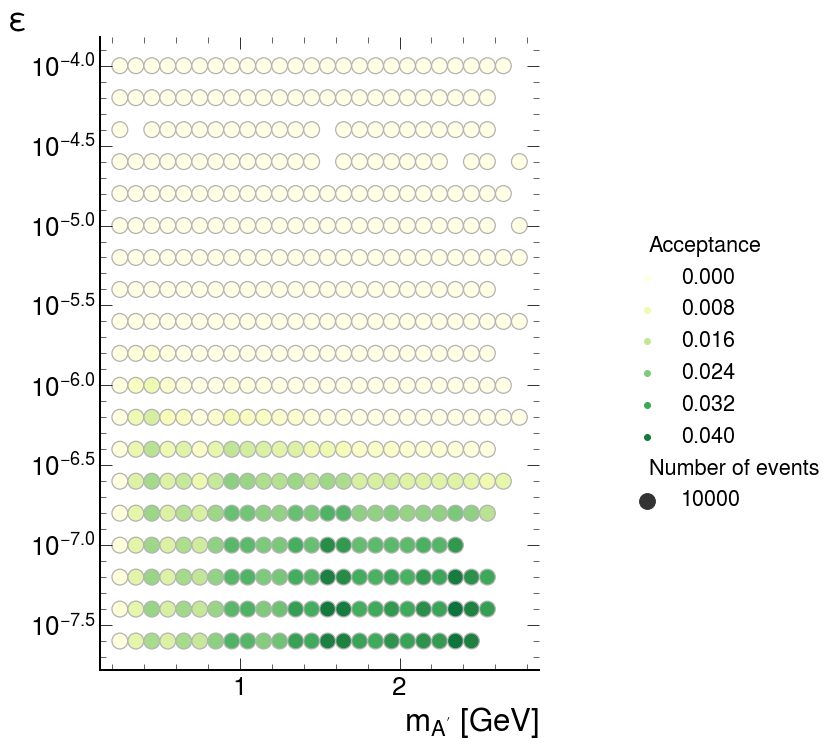

In [15]:
plot_acceptance(mass_4, coupling_4, Nevent_4, acceptance_4, hue_norm=(0, 0.05))

## 5. 1- fail all

In [ ]:
def scan_Ap_5(scan_dir):
    mass = []
    coupling = []
    Nevent = []
    acceptance = []

    #Loop through the files
    for filename in os.listdir(scan_dir):
        if filename.startswith("Brem"):
            
            try: 
                #Parse some basic info
                Ap_config = filename[:-5].split('_') #Remove the .root part and split by '_'

                #Load file and calculate total number of events
                dq_events = getData(os.path.join(scan_dir, filename), 'Events')

                #Total events
                n_events = len(dq_events["GenVertex"].x)
                Nevent.append(n_events)

                #Number of events reconstructed but not triggered
                n_reco = ak.sum((~(ak.count(dq_events["Track_St1"].x, axis = 1) == 2) &\
                                ~(dq_events["fpga_trigger"].trigger[:,0] == 1))*dq_events['event_weight'].weight)

                acceptance.append(1 - n_reco/n_events if n_events > 0 else 0)
                mass.append(float(Ap_config[1]))
                coupling.append(float(Ap_config[-1]))
                
            except:
                continue
            
#             print("---"*5)
#             print("Mass: ", Ap_config[1])
#             print("Coupling: ", Ap_config[-1])
#             print("Total number of events: ", n_events)
#             print("Number of events reconstructed", n_reco)
            
    return mass, coupling, Nevent, acceptance
            
mass_5, coupling_5, Nevent_5, acceptance_5 = scan_Ap_5(scan_dir)

In [ ]:
plot_acceptance(mass_5, coupling_5, Nevent_5, acceptance_5)